## Problema 1: Rotatividade de Funcionários

Temos observado uma alta taxa de rotatividade de funcionários em determinados departamentos. Gostaria que você investigasse os fatores que podem estar contribuindo para essa rotatividade, como:

- Departamentos com maior rotatividade
- Faixa etária dos funcionários que estão saindo
- Tempo de serviço dos funcionários que estão deixando a empresa
- Possíveis correlações com salários, benefícios ou outras variáveis

## Problema 2: Desempenho e Produtividade

Alguns gerentes têm relatado preocupações sobre o desempenho e a produtividade de suas equipes. Gostaria que você explorasse os dados para identificar possíveis fatores que possam estar influenciando o desempenho, como:

- Relação entre horas extras e produtividade
- Diferenças de desempenho entre departamentos ou funções

# 1.0 IMPORTS

In [278]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
from scipy                 import stats  as ss
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## 1.1 Loading Data

In [281]:
df1 = pd.read_csv('HR_Analytics.csv')
df1.head()

,EmpID,Age,AgeGroup,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,RM297,18,18-25,Yes,Travel_Rarely,230,Research & Development,3,3,Life Sciences,...,3,80,0,0,2,3,0,0,0,0.0
1,RM302,18,18-25,No,Travel_Rarely,812,Sales,10,3,Medical,...,1,80,0,0,2,3,0,0,0,0.0
2,RM458,18,18-25,Yes,Travel_Frequently,1306,Sales,5,3,Marketing,...,4,80,0,0,3,3,0,0,0,0.0
3,RM728,18,18-25,No,Non-Travel,287,Research & Development,5,2,Life Sciences,...,4,80,0,0,2,3,0,0,0,0.0
4,RM829,18,18-25,Yes,Non-Travel,247,Research & Development,8,1,Medical,...,4,80,0,0,0,3,0,0,0,0.0


## Helper Functions

In [282]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


# def mean_percentage_error( y, yhat ):
#     return np.mean( ( y - yhat ) / y )
     
    
# def mean_absolute_percentage_error( y, yhat ):
#     return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


# 2.0 DATA DESCRIPTION

Q: What's mean columns?
<br>Q: How can I solve the problem 1?

A: I need mind map of hyphotesis for me create and solve my questions.

In [283]:
df2 = df1.copy()

## 2.1 Lowercase columns

In [290]:
df2.columns = [x.lower() for x in df2.columns] # columns lowercase letters

## 2.2 Data Dimension

In [291]:
print('Columns:', df2.shape[1])
print('Rows:', df2.shape[0])

Columns: 38
Rows: 1480


## 2.3 Data Types

To make changes I need understand my datas.

In [292]:
df2.dtypes

empid                        object
age                           int64
agegroup                     object
attrition                    object
businesstravel               object
dailyrate                     int64
department                   object
distancefromhome              int64
education                     int64
educationfield               object
employeecount                 int64
employeenumber                int64
environmentsatisfaction       int64
gender                       object
hourlyrate                    int64
jobinvolvement                int64
joblevel                      int64
jobrole                      object
jobsatisfaction               int64
maritalstatus                object
monthlyincome                 int64
salaryslab                   object
monthlyrate                   int64
numcompaniesworked            int64
over18                       object
overtime                     object
percentsalaryhike             int64
performancerating           

## 2.4 Check NA

In [294]:
df2.isnull().sum()

empid                        0
age                          0
agegroup                     0
attrition                    0
businesstravel               0
dailyrate                    0
department                   0
distancefromhome             0
education                    0
educationfield               0
employeecount                0
employeenumber               0
environmentsatisfaction      0
gender                       0
hourlyrate                   0
jobinvolvement               0
joblevel                     0
jobrole                      0
jobsatisfaction              0
maritalstatus                0
monthlyincome                0
salaryslab                   0
monthlyrate                  0
numcompaniesworked           0
over18                       0
overtime                     0
percentsalaryhike            0
performancerating            0
relationshipsatisfaction     0
standardhours                0
stockoptionlevel             0
totalworkingyears            0
training

I have just 57 nulls data. Then, I can just exclude it.

### 2.4.1 Exclude NULL

In [296]:
df2.yearswithcurrmanager.fillna(0, inplace=True)

## 2.5 Change Types

In this project cycle I will opt for the quick response, in the next cycle after improving the result I will see what can be done in relation to this step.

# 3.0 Descriptive Statistical

In [297]:
df3 = df2.copy()

In [298]:
num_attrs = df3.select_dtypes(include=['int64', 'int32',  'float64'])
cat_attrs = df3.select_dtypes(exclude=['int32', 'int64', 'float64', 'datetime64[ns]'])

## 3.1 Numerical Attributes

In [299]:
ct1 = pd.DataFrame(num_attrs.apply(np.mean)).T
ct2 = pd.DataFrame(num_attrs.apply(np.median)).T

d1 = pd.DataFrame(num_attrs.apply(np.std)).T
d2 = pd.DataFrame(num_attrs.apply(min)).T
d3 = pd.DataFrame(num_attrs.apply(max)).T
d4 = pd.DataFrame(num_attrs.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attrs.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attrs.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2,d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attrs', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attrs,min,max,range,mean,median,std,skew,kurtosis
0,age,18.0,60.0,42.0,36.917568,36.0,9.125475,0.414355,-0.405114
1,dailyrate,102.0,1499.0,1397.0,801.384459,800.0,402.990774,0.000246,-1.201903
2,distancefromhome,1.0,29.0,28.0,9.220270,7.0,8.128453,0.956145,-0.237142
3,education,1.0,5.0,4.0,2.910811,3.0,1.023450,-0.290327,-0.556773
4,employeecount,1.0,1.0,0.0,1.000000,1.0,0.000000,0.000000,0.000000
5,employeenumber,1.0,2068.0,2067.0,1031.860811,1027.5,605.750297,0.015234,-1.224390
6,environmentsatisfaction,1.0,4.0,3.0,2.724324,3.0,1.092210,-0.322294,-1.201550
7,hourlyrate,30.0,100.0,70.0,65.845270,66.0,20.321397,-0.031804,-1.195964
8,jobinvolvement,1.0,4.0,3.0,2.729730,3.0,0.712766,-0.484030,0.246918
9,joblevel,1.0,5.0,4.0,2.064865,2.0,1.105201,1.022990,0.397651


# 4.0 FEATURE ENGINEERING

In [300]:
df4 = df3.copy()

create mind map of hyphotesis

<img src='Mind Map.jpg'>

In [301]:
pessoas_cols = df4[['empid', 'gender', 'maritalstatus', 'agegroup', 'over18', 'age', 'distancefromhome', 'attrition']]
emprego_cols = df4[['employeecount', 'employeenumber', 'joblevel', 'jobrole', 'yearsatcompany', 'yearsincurrentrole', 'yearswithcurrmanager', 'yearssincelastpromotion', 'businesstravel', 'department', 'standardhours', 'overtime', 'attrition']]
renda_beneficios_cols = df4[['dailyrate', 'hourlyrate', 'monthlyincome', 'monthlyrate', 'numcompaniesworked', 'percentsalaryhike', 'salaryslab', 'stockoptionlevel', 'totalworkingyears', 'attrition']]
educacao_treinamento_cols = df4[['education', 'educationfield', 'trainingtimeslastyear', 'attrition']]
satisfacao_desenvolvimento_cols = df4[['environmentsatisfaction', 'jobinvolvement', 'relationshipsatisfaction', 'worklifebalance', 'jobsatisfaction', 'performancerating', 'attrition']]

## Analysis Response Variable

### Attrition Rate

In [302]:
attrition_rate = df4['attrition'].value_counts(normalize=True) * 100
print(attrition_rate)

attrition
No     83.918919
Yes    16.081081
Name: proportion, dtype: float64


### Attrition por Pessoas

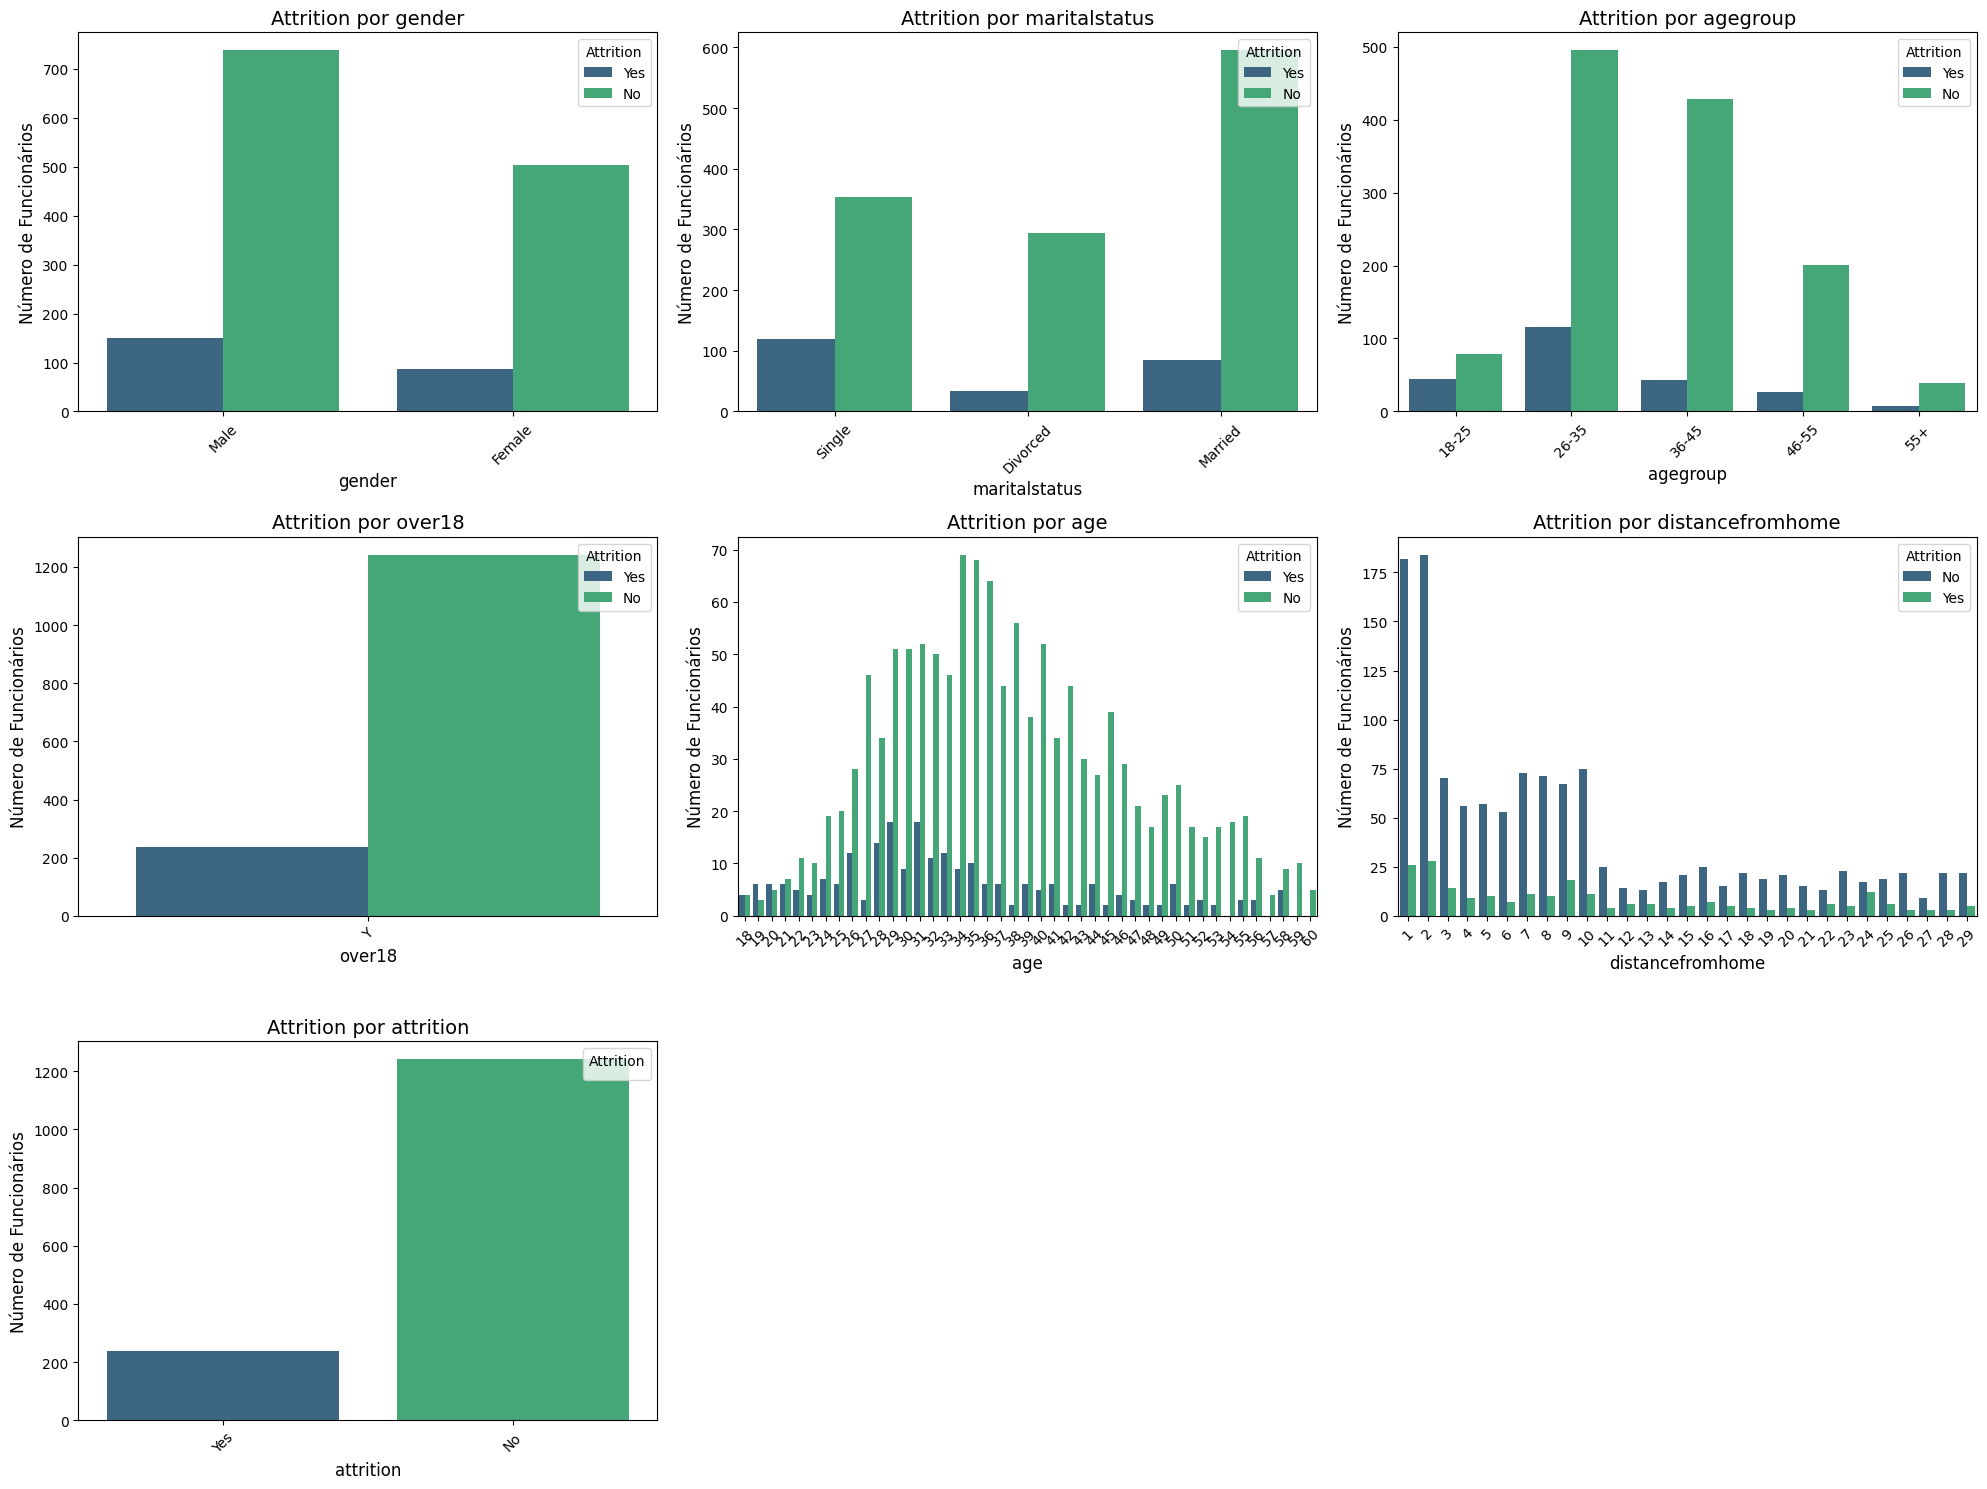

In [303]:
# Configurar o número de colunas e linhas para subplots
columns = pessoas_cols.drop(columns=['empid']).columns
n_cols = 3  # Número de gráficos por linha
n_rows = (len(columns) + n_cols - 1) // n_cols  # Calcular o número de linhas

# Criar a figura e os subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))  # Ajustar tamanho da figura
axes = axes.flatten()  # Achatar os eixos para facilitar a iteração

# Iterar pelas colunas e criar gráficos
for i, x in enumerate(columns):
    sns.countplot(data=pessoas_cols, x=x, hue='attrition', palette='viridis', ax=axes[i])
    axes[i].set_title(f'Attrition por {x}', fontsize=14)
    axes[i].set_xlabel(f'{x}', fontsize=12)
    axes[i].set_ylabel('Número de Funcionários', fontsize=12)
    axes[i].legend(title='Attrition', loc='upper right')
    axes[i].tick_params(axis='x', rotation=45)

# Remover gráficos vazios se houver menos colunas que subplots
for i in range(len(columns), len(axes)):
    fig.delaxes(axes[i])

# Ajustar layout
plt.tight_layout()
plt.show()


## Attrition por Emprego

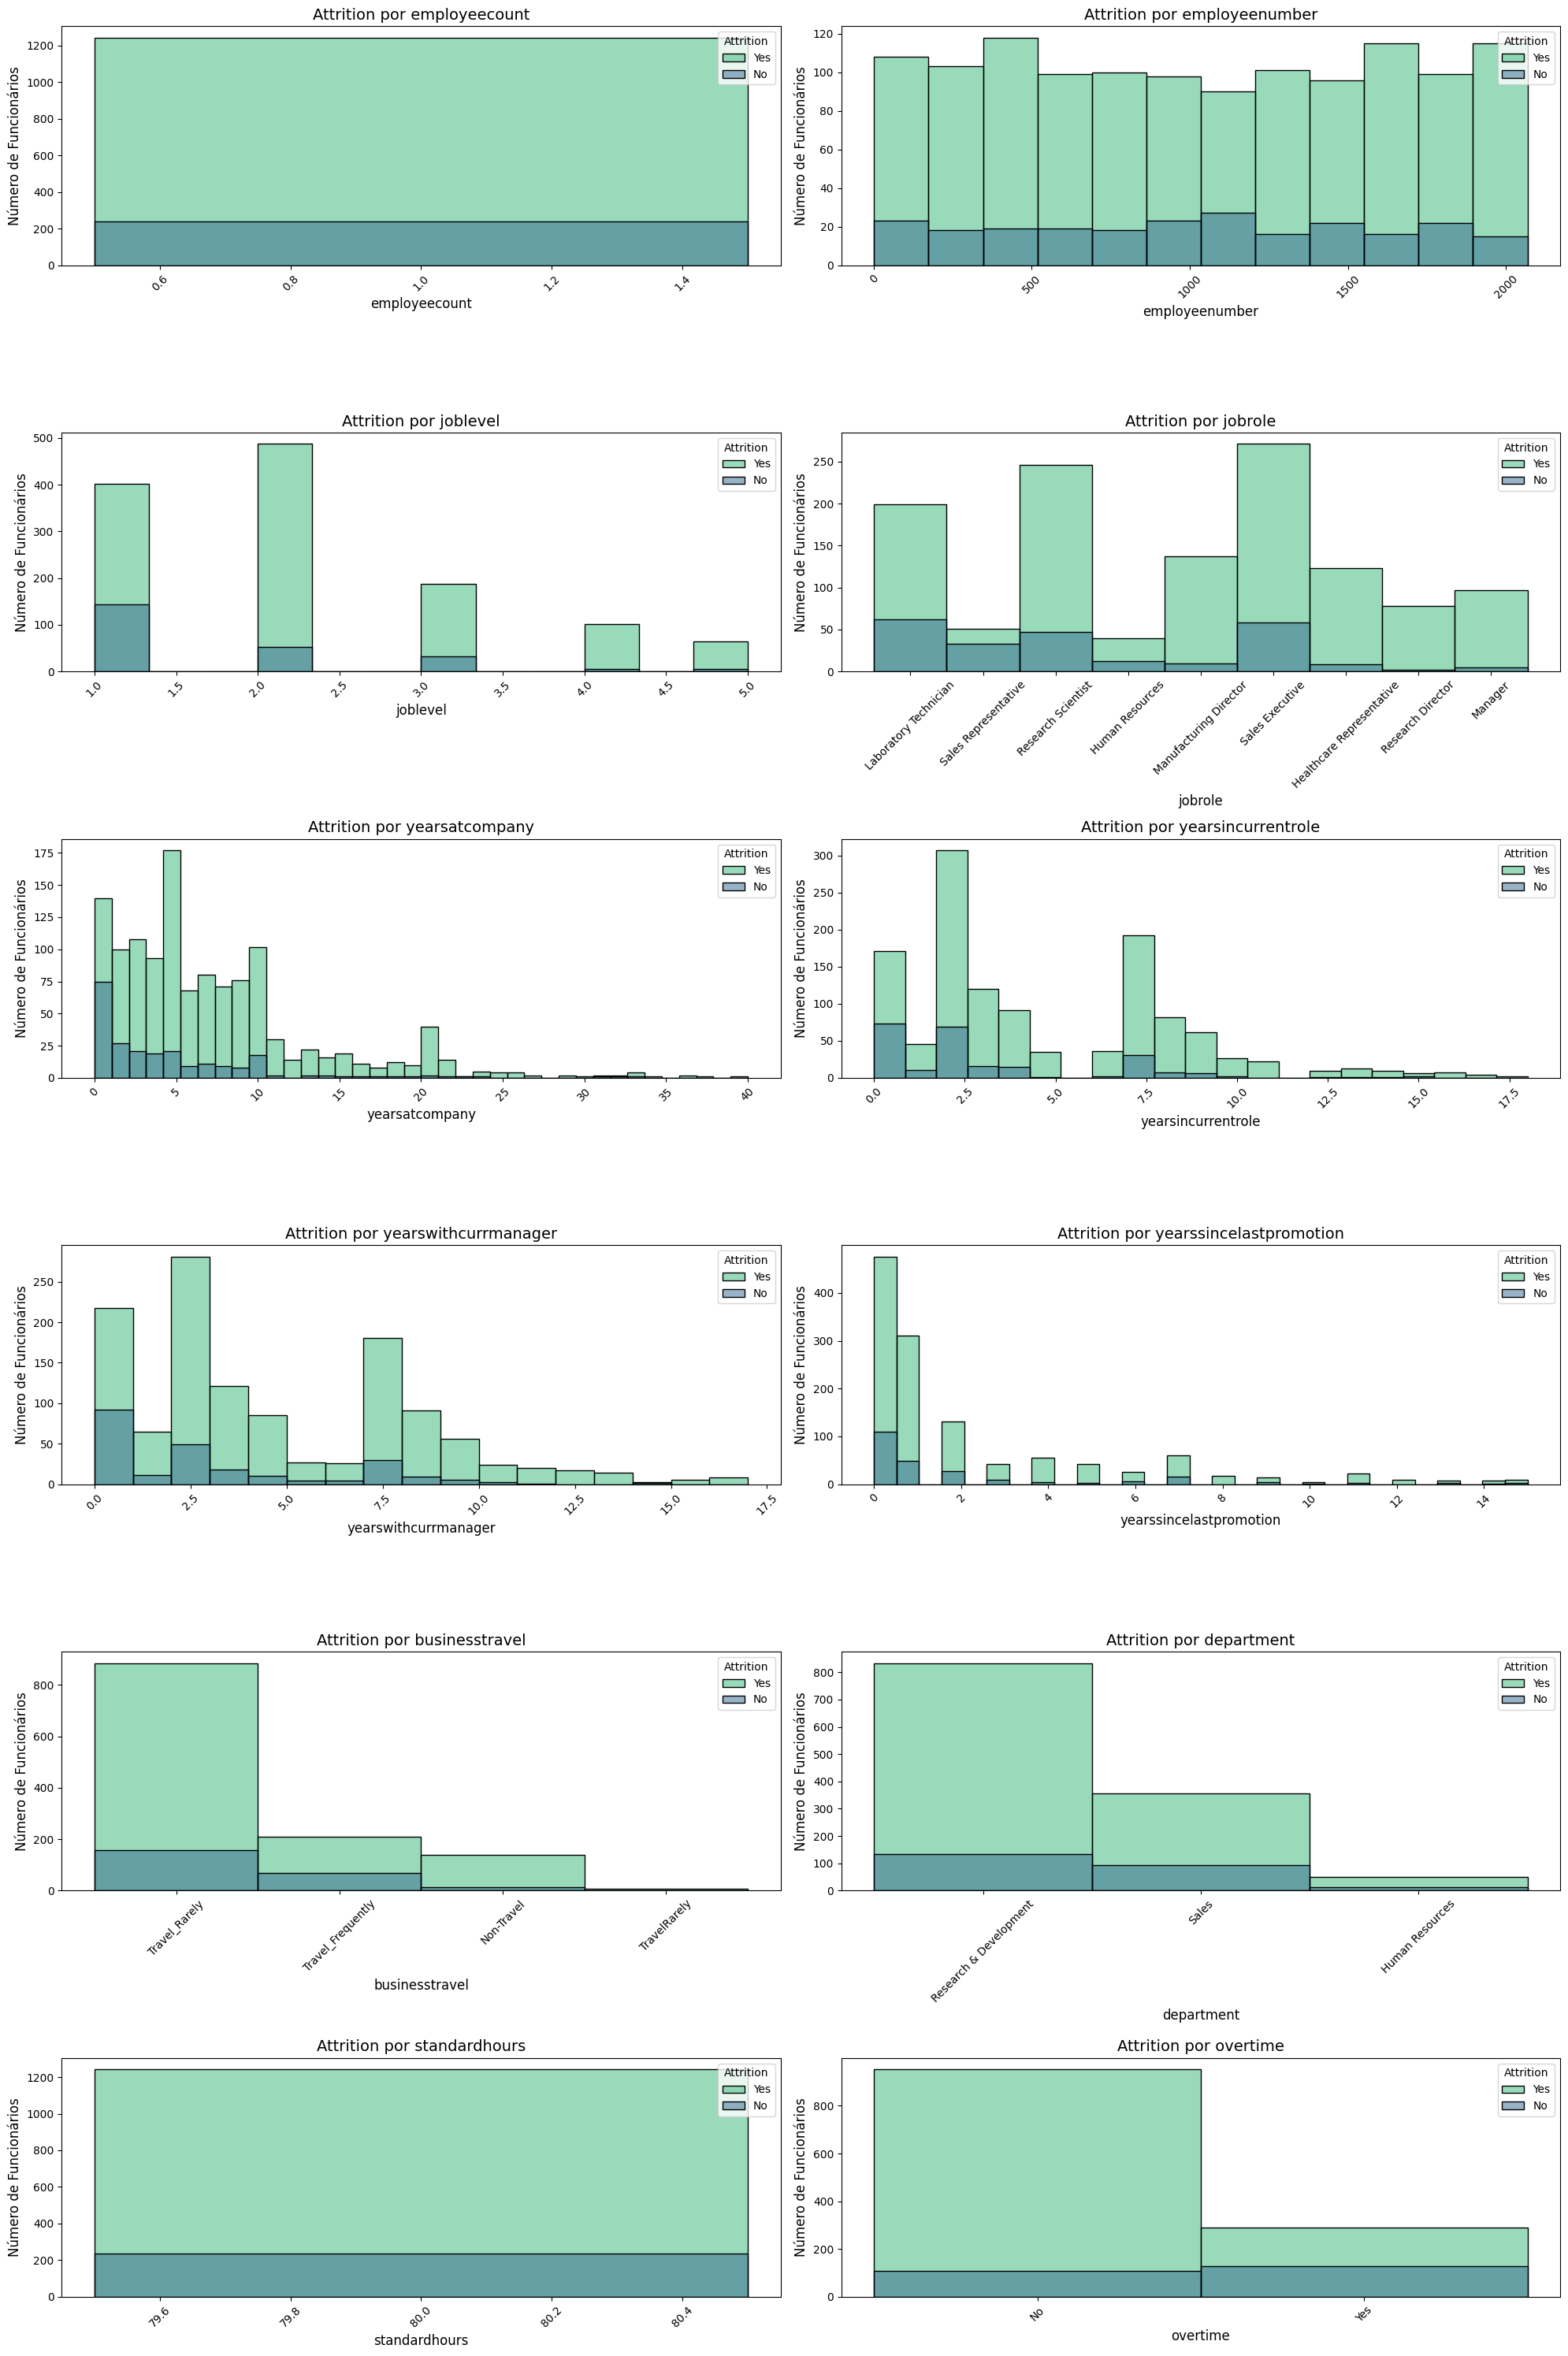

In [304]:
# Configurar o número de colunas e linhas para subplots
columns = emprego_cols.drop(columns=['attrition']).columns
n_cols = 2  # Número de gráficos por linha
n_rows = (len(columns) + n_cols - 1) // n_cols  # Calcular o número de linhas

# Criar a figura e os subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))  # Ajustar tamanho da figura
axes = axes.flatten()  # Achatar os eixos para facilitar a iteração

# Iterar pelas colunas e criar gráficos
for i, x in enumerate(columns):
    sns.histplot(data=emprego_cols, x=x, hue='attrition', palette='viridis', ax=axes[i])
    axes[i].set_title(f'Attrition por {x}', fontsize=14)
    axes[i].set_xlabel(f'{x}', fontsize=12)
    axes[i].set_ylabel('Número de Funcionários', fontsize=12)
    axes[i].legend(labels=['Yes', 'No'], title='Attrition', loc='upper right')
    axes[i].tick_params(axis='x', rotation=45)

# Remover gráficos vazios se houver menos colunas que subplots
for i in range(len(columns), len(axes)):
    fig.delaxes(axes[i])

# Ajustar layout
plt.tight_layout()
plt.show()


## Attrition por Renda e Beneficios

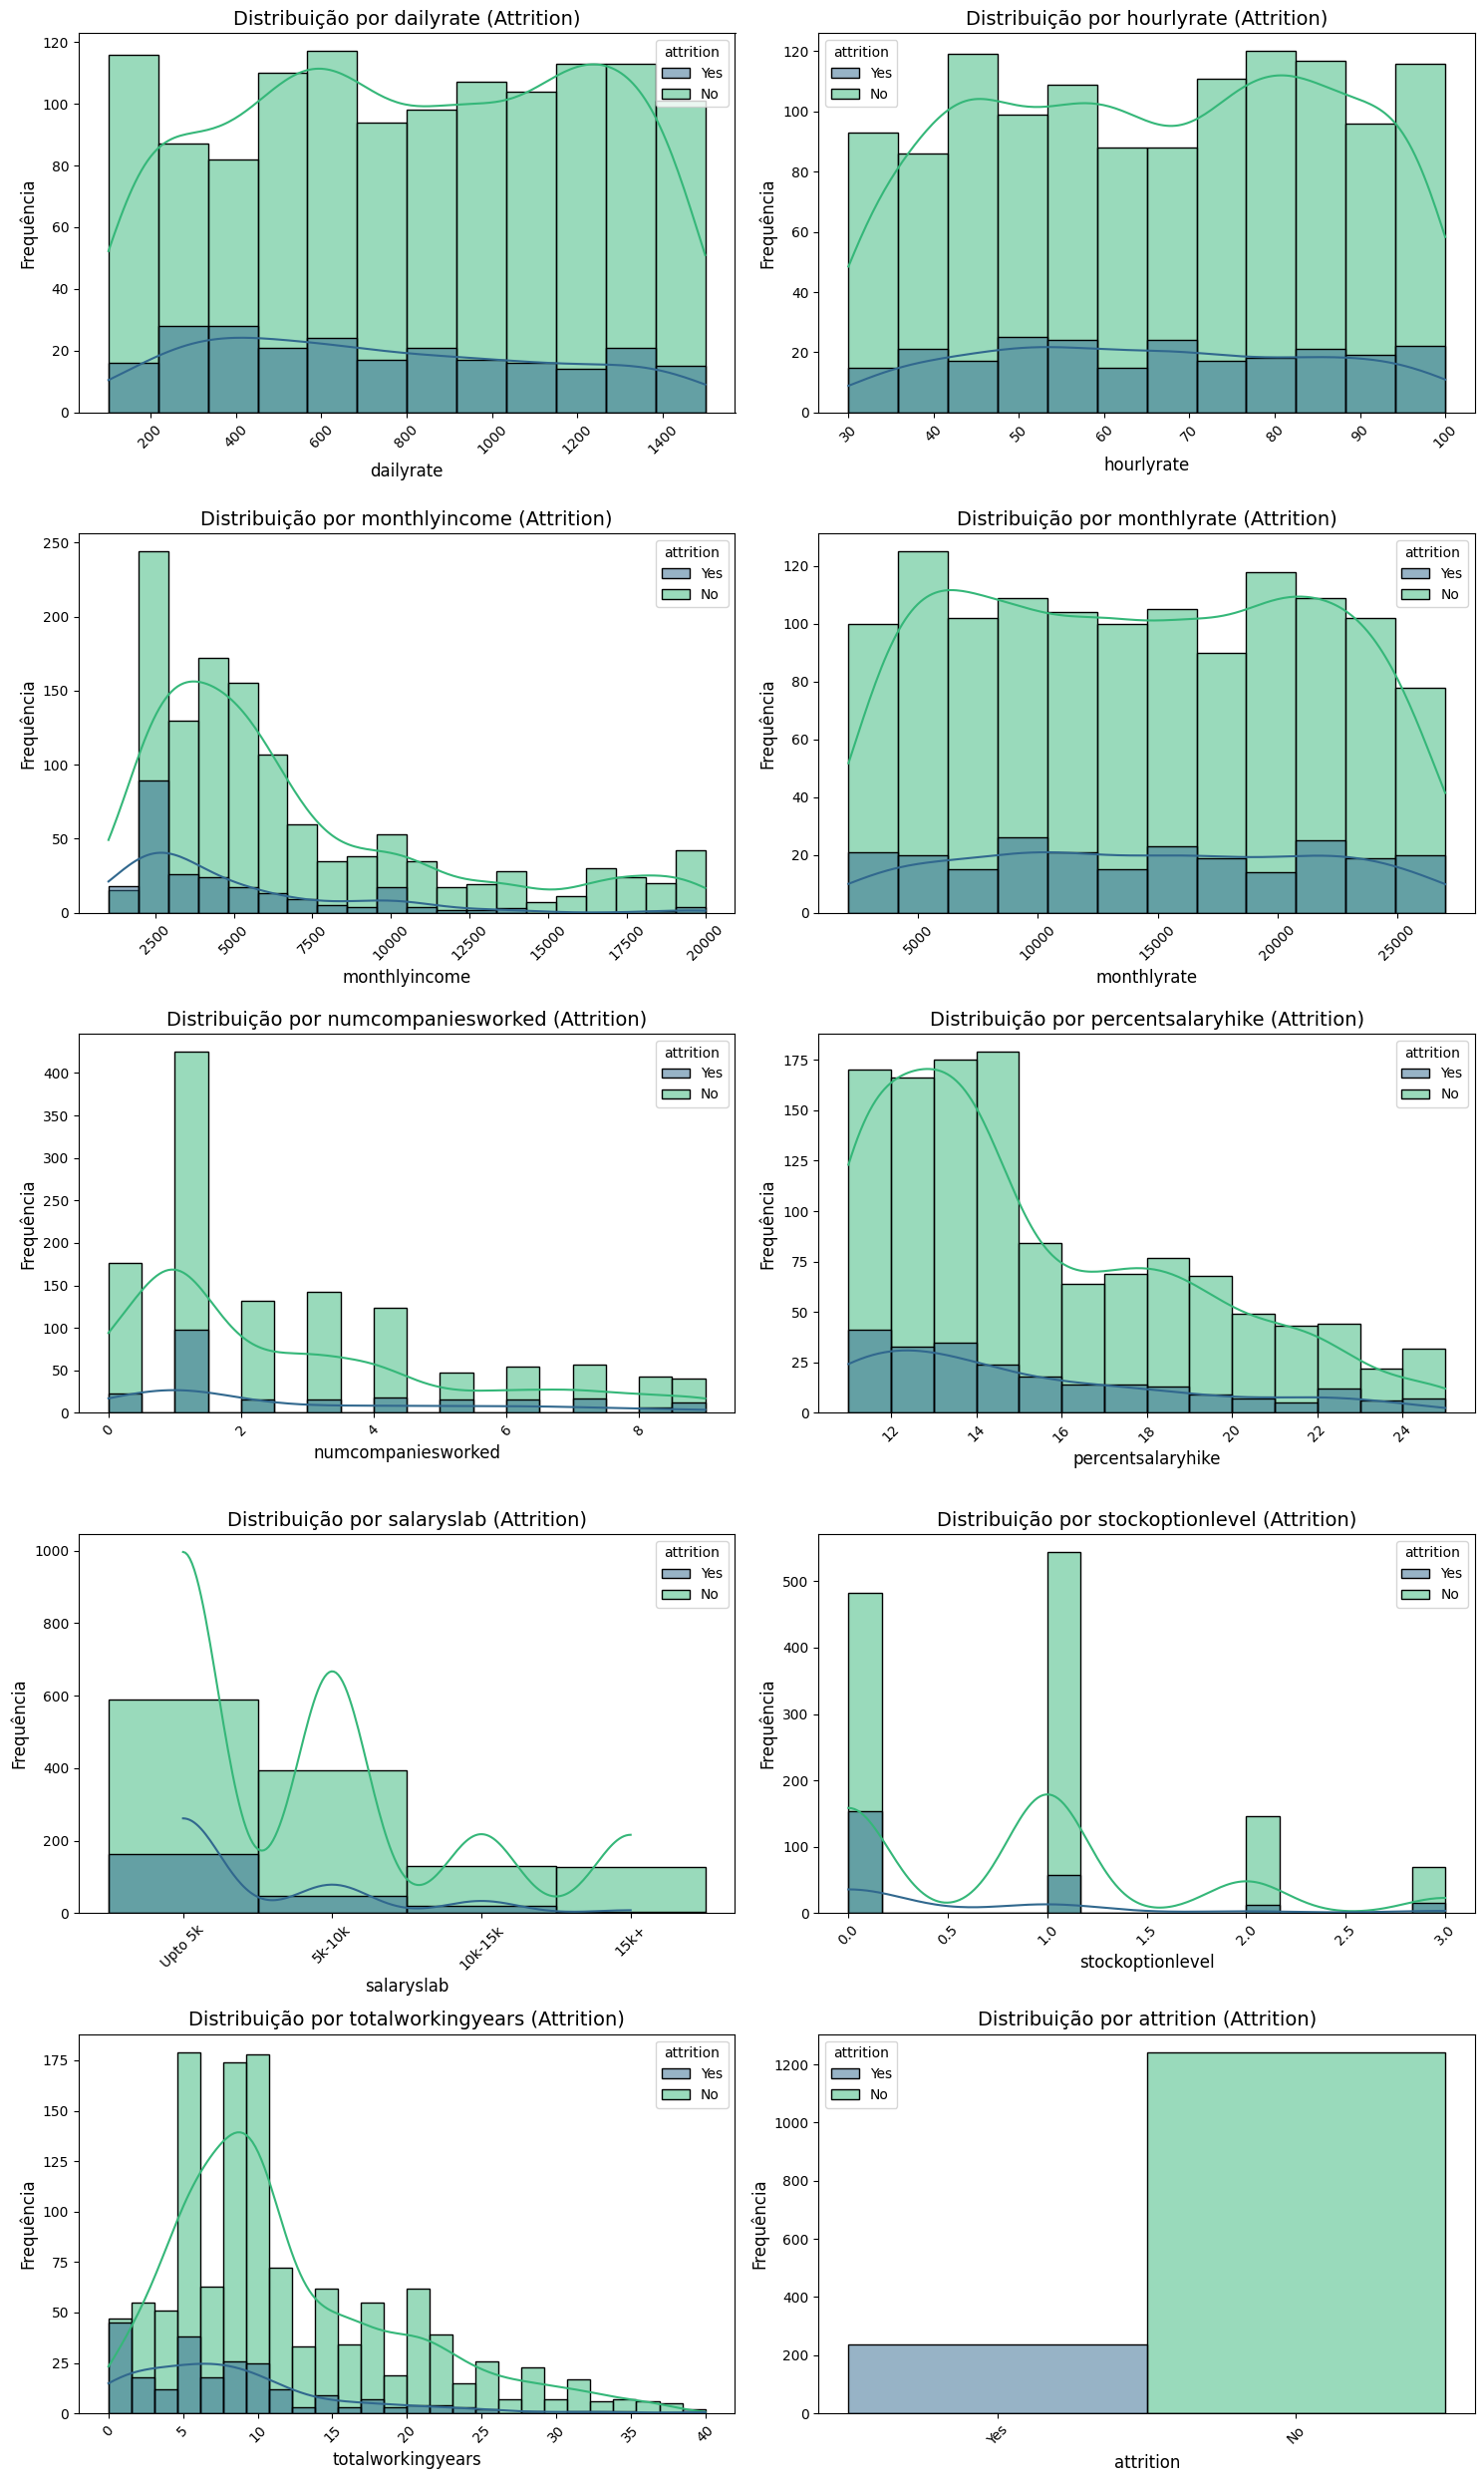

In [305]:
# Configurar o número de colunas e linhas para subplots
columns = renda_beneficios_cols.columns  # Apenas os nomes das colunas
n_cols = 2  # Número de gráficos por linha
n_rows = (len(columns) + n_cols - 1) // n_cols  # Calcular o número de linhas

# Criar a figura e os subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Ajustar tamanho da figura
axes = axes.flatten()  # Achatar os eixos para facilitar a iteração

# Iterar pelas colunas e criar gráficos
for i, x in enumerate(columns):
    sns.histplot(data=renda_beneficios_cols, x=x, hue='attrition', palette='viridis', ax=axes[i], kde=True)
    axes[i].set_title(f'Distribuição por {x} (Attrition)', fontsize=14)
    axes[i].set_xlabel(f'{x}', fontsize=12)
    axes[i].set_ylabel('Frequência', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

# Remover gráficos vazios se houver menos colunas que subplots
for i in range(len(columns), len(axes)):
    fig.delaxes(axes[i])

# Ajustar layout
plt.tight_layout()
plt.show()


## Attrition por Educação e Treinamento

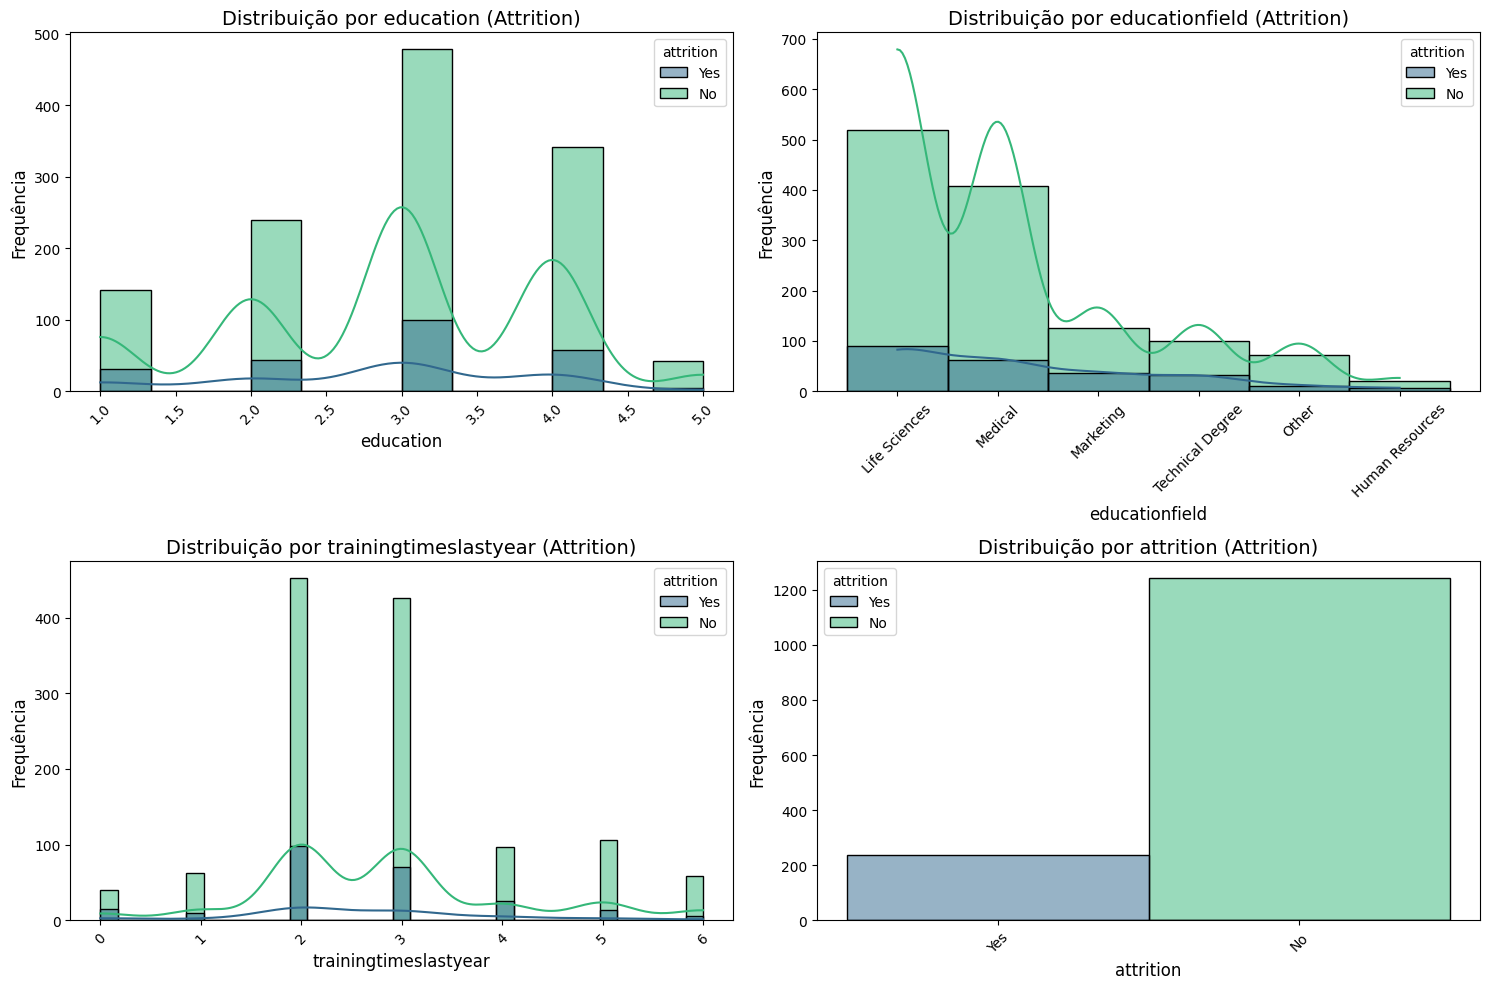

In [306]:
# Configurar o número de colunas e linhas para subplots
columns = educacao_treinamento_cols.columns  # Apenas os nomes das colunas
n_cols = 2  # Número de gráficos por linha
n_rows = (len(columns) + n_cols - 1) // n_cols  # Calcular o número de linhas

# Criar a figura e os subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Ajustar tamanho da figura
axes = axes.flatten()  # Achatar os eixos para facilitar a iteração

# Iterar pelas colunas e criar gráficos
for i, x in enumerate(columns):
    sns.histplot(data=educacao_treinamento_cols, x=x, hue='attrition', palette='viridis', ax=axes[i], kde=True)
    axes[i].set_title(f'Distribuição por {x} (Attrition)', fontsize=14)
    axes[i].set_xlabel(f'{x}', fontsize=12)
    axes[i].set_ylabel('Frequência', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

# Remover gráficos vazios se houver menos colunas que subplots
for i in range(len(columns), len(axes)):
    fig.delaxes(axes[i])

# Ajustar layout
plt.tight_layout()
plt.show()


## Attrition por Satisfação e Desenvolvimento

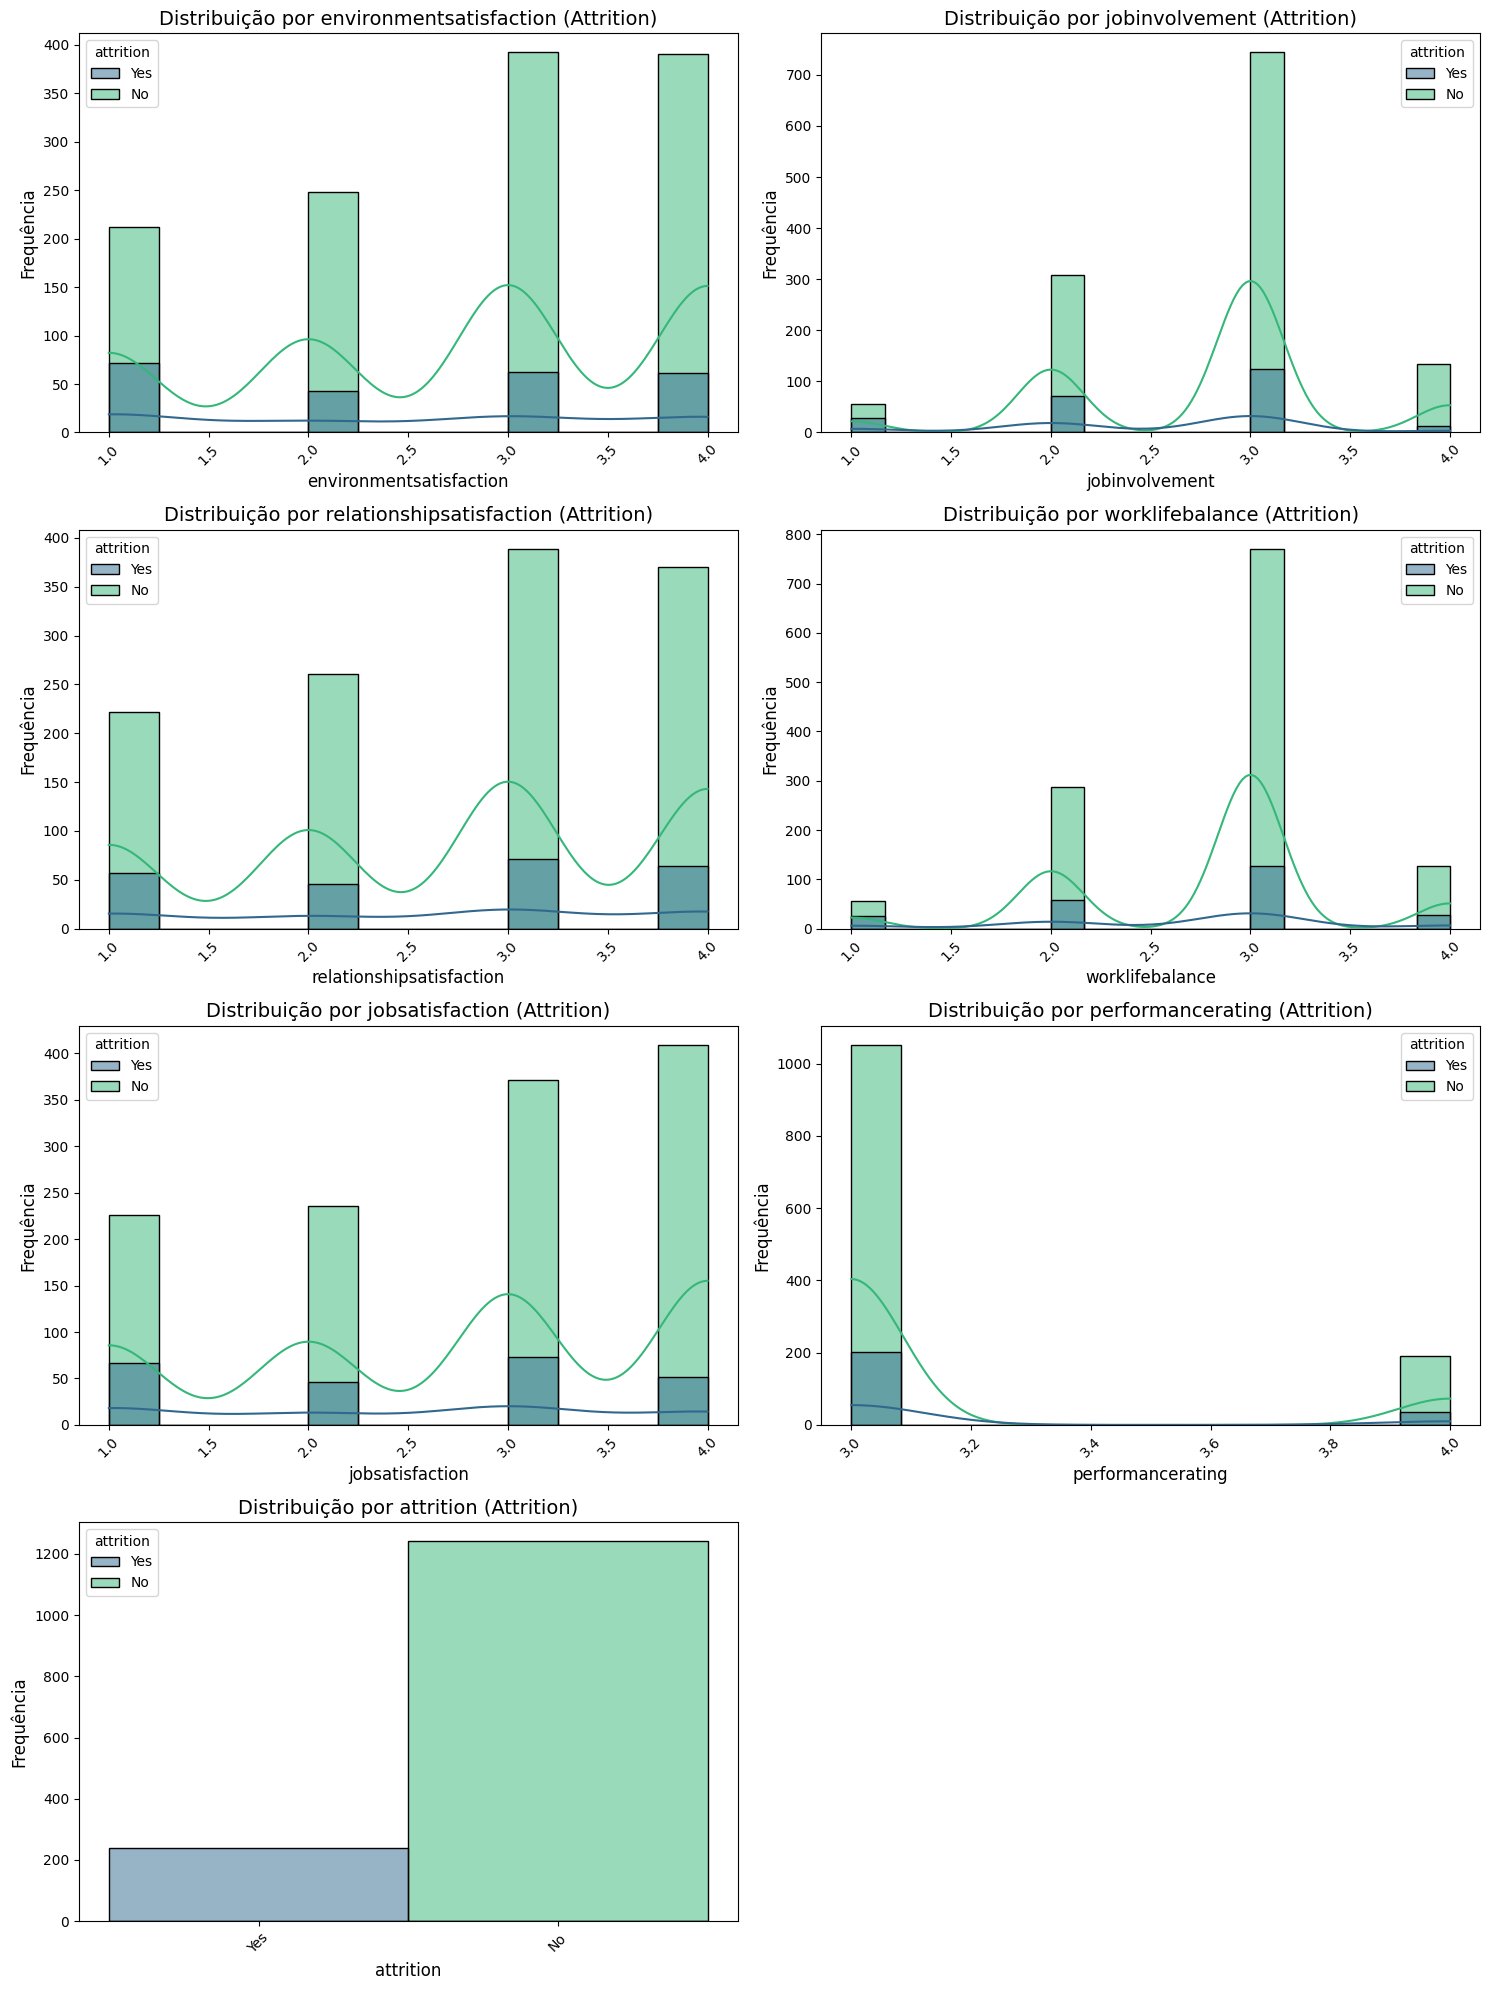

In [307]:
# Configurar o número de colunas e linhas para subplots
columns = satisfacao_desenvolvimento_cols.columns  # Apenas os nomes das colunas
n_cols = 2  # Número de gráficos por linha
n_rows = (len(columns) + n_cols - 1) // n_cols  # Calcular o número de linhas

# Criar a figura e os subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Ajustar tamanho da figura
axes = axes.flatten()  # Achatar os eixos para facilitar a iteração

# Iterar pelas colunas e criar gráficos
for i, x in enumerate(columns):
    sns.histplot(data=satisfacao_desenvolvimento_cols, x=x, hue='attrition', palette='viridis', ax=axes[i], kde=True)
    axes[i].set_title(f'Distribuição por {x} (Attrition)', fontsize=14)
    axes[i].set_xlabel(f'{x}', fontsize=12)
    axes[i].set_ylabel('Frequência', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

# Remover gráficos vazios se houver menos colunas que subplots
for i in range(len(columns), len(axes)):
    fig.delaxes(axes[i])

# Ajustar layout
plt.tight_layout()
plt.show()


# RESPONDING TO EMAIL

## Problema 1: Rotatividade de Funcionários

### Departamentos com maior rotatividade

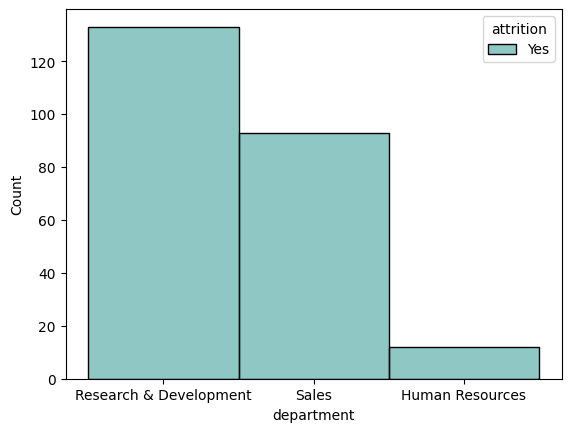

In [308]:
aux = emprego_cols[['department', 'attrition']][emprego_cols['attrition'] == 'Yes']
sns.histplot(data=aux, x=aux['department'], hue='attrition', palette='viridis');

### Faixa etária dos funcionários que estão saindo

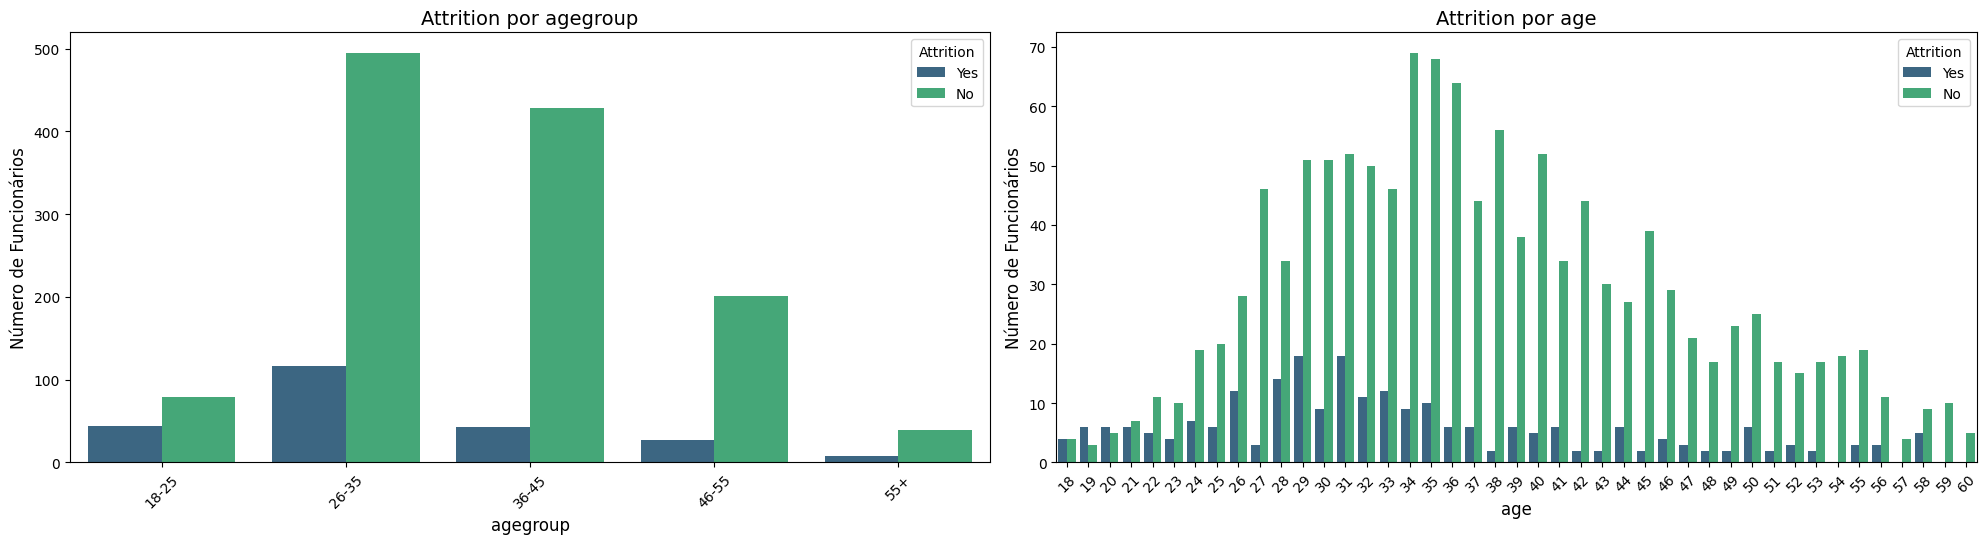

In [309]:
# Configurar o número de colunas e linhas para subplots
aux = pessoas_cols[['agegroup', 'age', 'attrition']]
columns = aux.columns
n_cols = 2  # Número de gráficos por linha
n_rows = (len(columns) + n_cols - 1) // n_cols  # Calcular o número de linhas

# Criar a figura e os subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))  # Ajustar tamanho da figura
axes = axes.flatten()  # Achatar os eixos para facilitar a iteração

# Iterar pelas colunas e criar gráficos
for i, x in enumerate(columns):
    if x == 'attrition':
        fig.delaxes(axes[i])
    else:
        sns.countplot(data=aux, x=x, hue='attrition', palette='viridis', ax=axes[i])
        axes[i].set_title(f'Attrition por {x}', fontsize=14)
        axes[i].set_xlabel(f'{x}', fontsize=12)
        axes[i].set_ylabel('Número de Funcionários', fontsize=12)
        axes[i].legend(title='Attrition', loc='upper right')
        axes[i].tick_params(axis='x', rotation=45)

# Remover gráficos vazios se houver menos colunas que subplots
for i in range(len(columns), len(axes)):
    fig.delaxes(axes[i])

# Ajustar layout
plt.tight_layout()
plt.show()


### Tempo de serviço dos funcionários que estão deixando a empresa

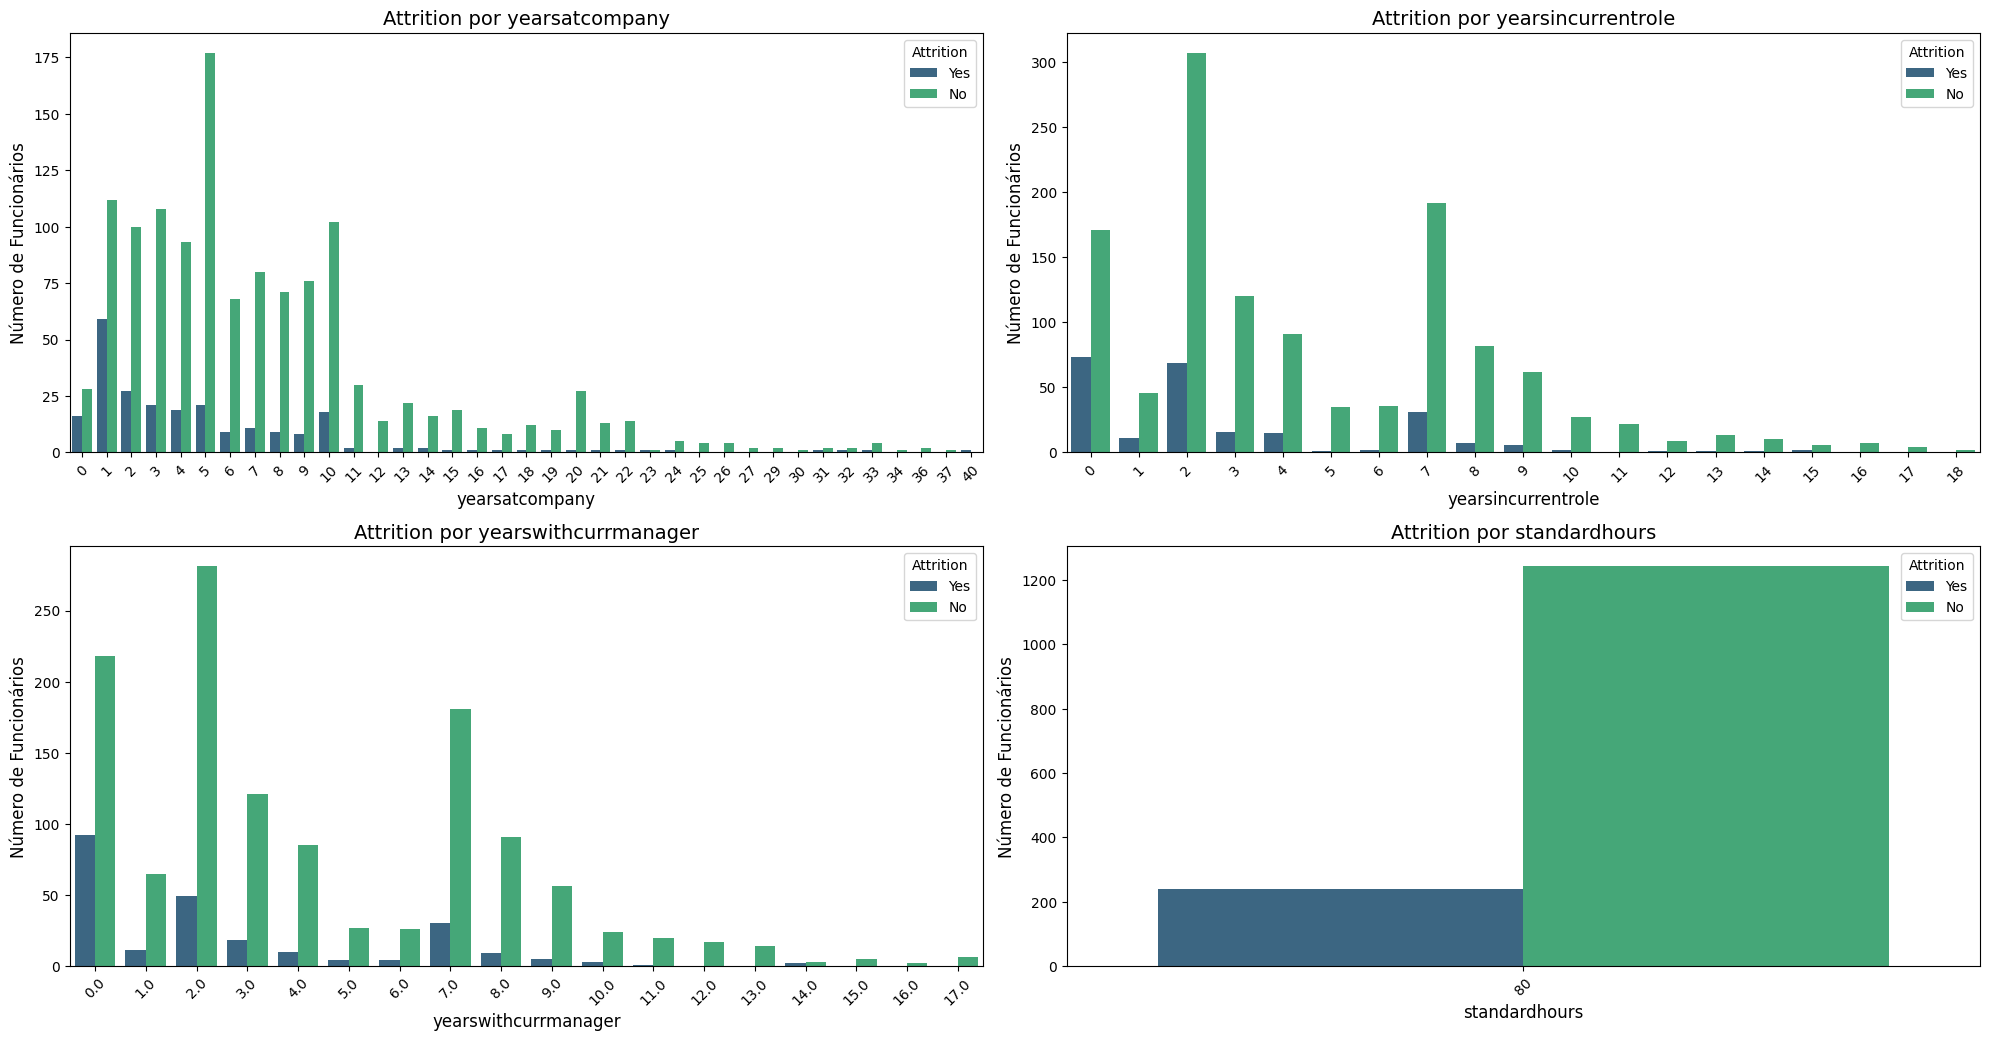

In [310]:
# Configurar o número de colunas e linhas para subplots
aux = emprego_cols[['yearsatcompany', 'yearsincurrentrole', 'yearswithcurrmanager', 'standardhours', 'attrition']]
columns = aux.columns
n_cols = 2  # Número de gráficos por linha
n_rows = (len(columns) + n_cols - 1) // n_cols  # Calcular o número de linhas

# Criar a figura e os subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))  # Ajustar tamanho da figura
axes = axes.flatten()  # Achatar os eixos para facilitar a iteração

# Iterar pelas colunas e criar gráficos
for i, x in enumerate(columns):
    if x == 'attrition':
        fig.delaxes(axes[i])
    else:
        sns.countplot(data=aux, x=x, hue='attrition', palette='viridis', ax=axes[i])
        axes[i].set_title(f'Attrition por {x}', fontsize=14)
        axes[i].set_xlabel(f'{x}', fontsize=12)
        axes[i].set_ylabel('Número de Funcionários', fontsize=12)
        axes[i].legend(title='Attrition', loc='upper right')
        axes[i].tick_params(axis='x', rotation=45)

# Remover gráficos vazios se houver menos colunas que subplots
for i in range(len(columns), len(axes)):
    fig.delaxes(axes[i])

# Ajustar layout
plt.tight_layout()
plt.show()


## Problema 2: Desempenho e Produtividade

### Relação entre horas extras e produtividade


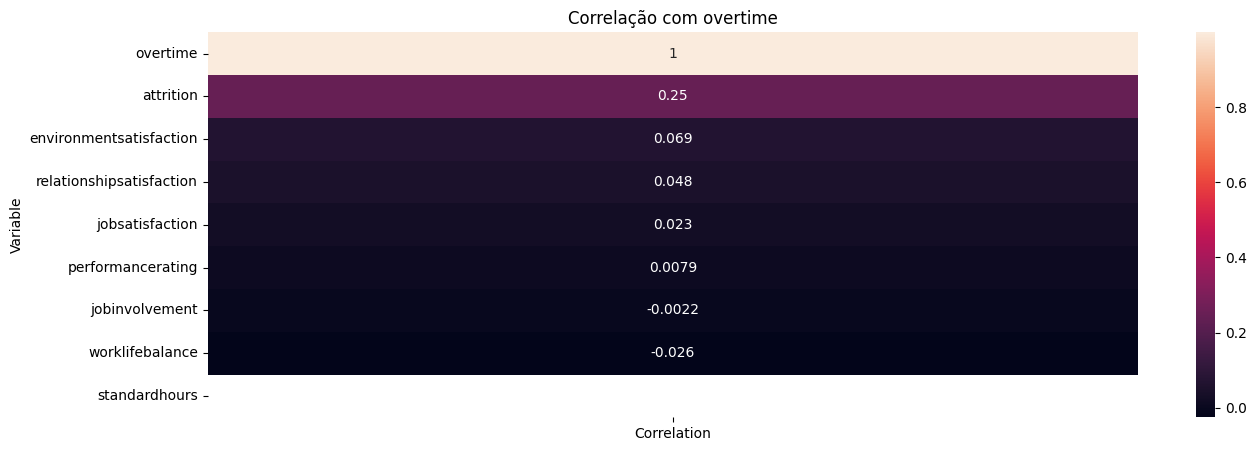

In [311]:
aux_df = pd.merge(emprego_cols[['overtime', 'standardhours', 'attrition']], satisfacao_desenvolvimento_cols, on='attrition')
aux_num = aux_df.select_dtypes('int64')
aux_cat = aux_df.select_dtypes('object')

df4['overtime_encoded'] = df4['overtime'].apply(lambda x: 1 if x == 'Yes' else 0)

numerical_corr = {}
for col in aux_num:
    numerical_corr[col] = df4[col].corr(df4['overtime_encoded'], method='pearson')

categorical_corr = {}
for col in aux_cat:
    categorical_corr[col] = cramer_v(df4[col], df4['overtime'])


correlation_results = pd.DataFrame({
    'Variable': list(categorical_corr.keys()) + list(numerical_corr.keys()),
    'Correlation': list(categorical_corr.values()) + list(numerical_corr.values())
})

heatmap_data = correlation_results.set_index('Variable').sort_values(by=['Correlation'], ascending=False)


fig, ax = plt.subplots(figsize=(15,5)) 
plt.title('Correlação com overtime')
sns.heatmap(heatmap_data, annot=True, ax=ax);

Insights:

- Horas Extras contribui mais para o desligamento (25% de relação, ou seja, mais trabalho mais desligamento)
- Quem faz mais Horas Extras não influencia no Envolvimento, Relação ou Perfomance Rating dos funcionarios. ( correlação proxima de 0%)
- Quem faz mais Horas Extras tem uma pode ter uma vida mais desequilibrada. ( -0.026 )

### Diferenças de desempenho entre departamentos ou funções

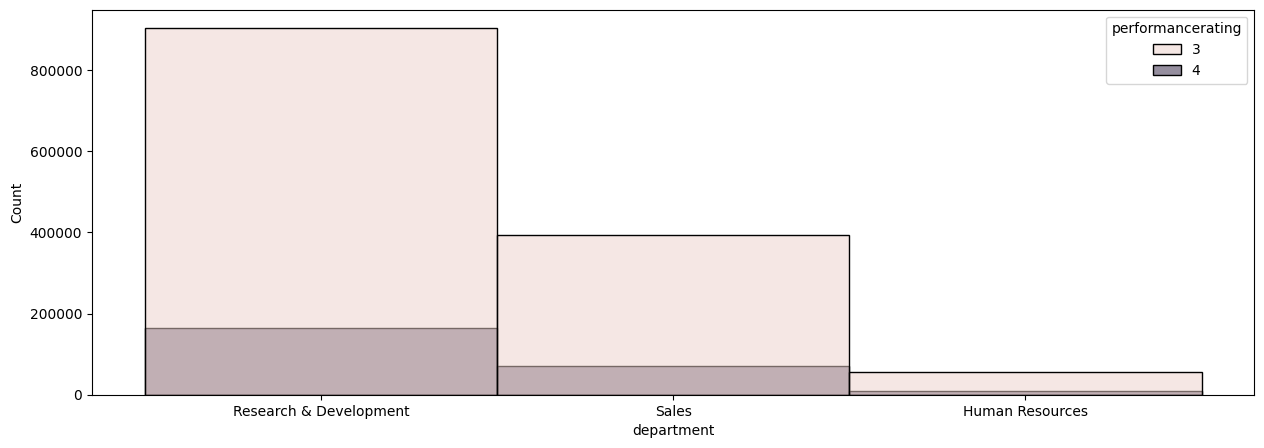

In [312]:
aux_df = pd.merge(satisfacao_desenvolvimento_cols[['performancerating', 'attrition']], emprego_cols[['department', 'attrition']]).drop(columns=['attrition'])
fig, ax = plt.subplots(figsize=(15,5)) 
sns.histplot(data=aux_df, x='department', hue='performancerating', ax=ax);

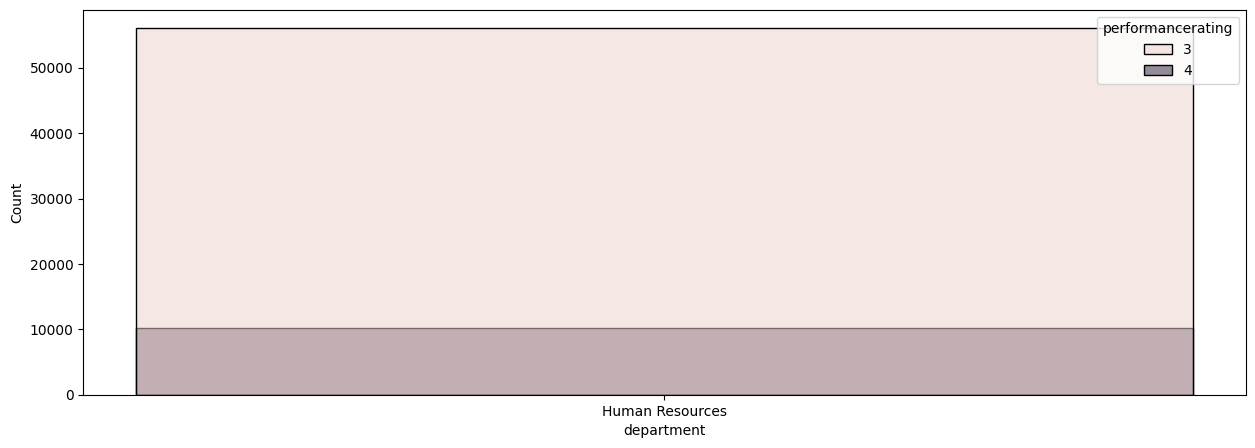

In [313]:
aux_df = pd.merge(satisfacao_desenvolvimento_cols[['performancerating', 'attrition']], emprego_cols[['department', 'attrition']]).drop(columns=['attrition'])
aux_df = aux_df[aux_df['department'] == 'Human Resources']
fig, ax = plt.subplots(figsize=(15,5)) 
sns.histplot(data=aux_df, x='department', hue='performancerating', ax=ax);

# Multivariate Analysis

## Numerical

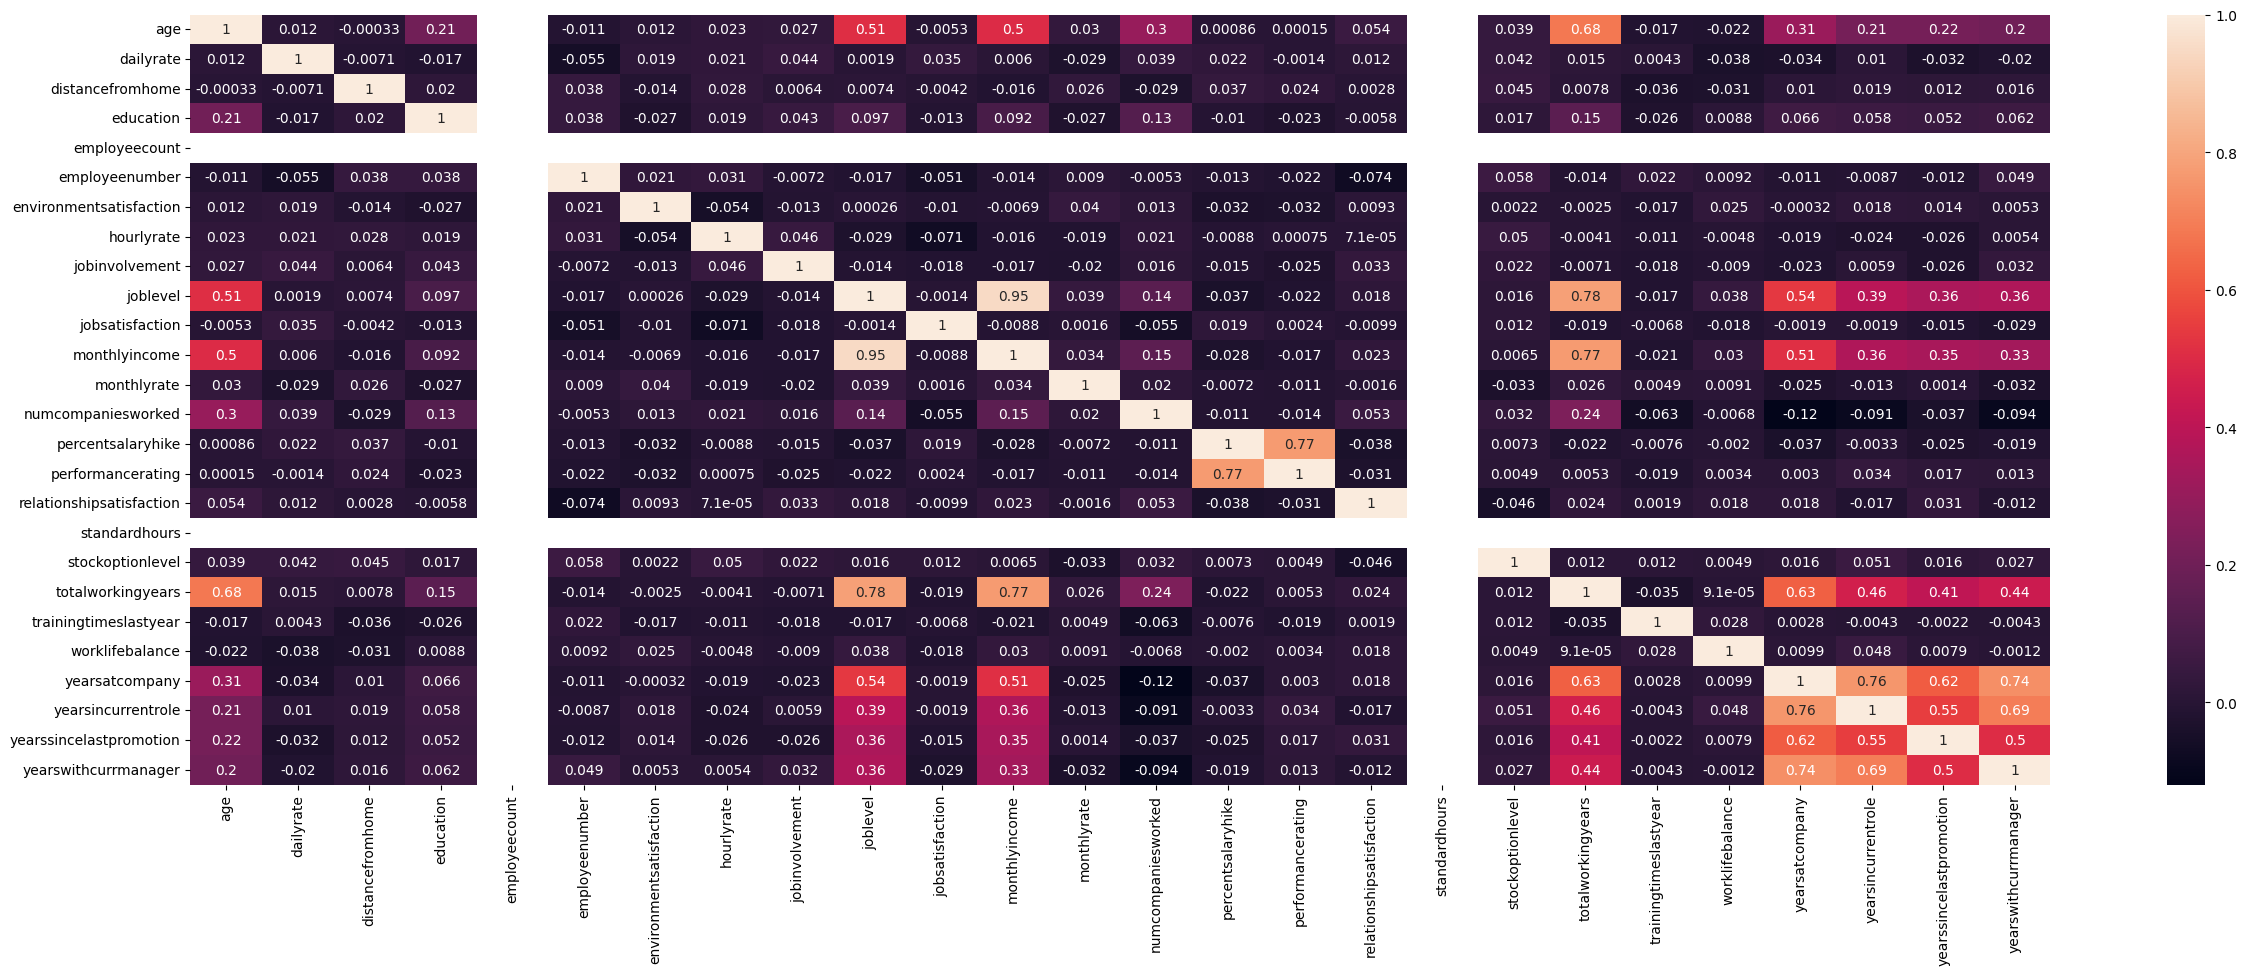

In [314]:
correlation = num_attrs.corr( method='pearson' )
fig, ax = plt.subplots(figsize=(30,10)) 
sns.heatmap( correlation, annot=True, ax=ax );

## Categorical

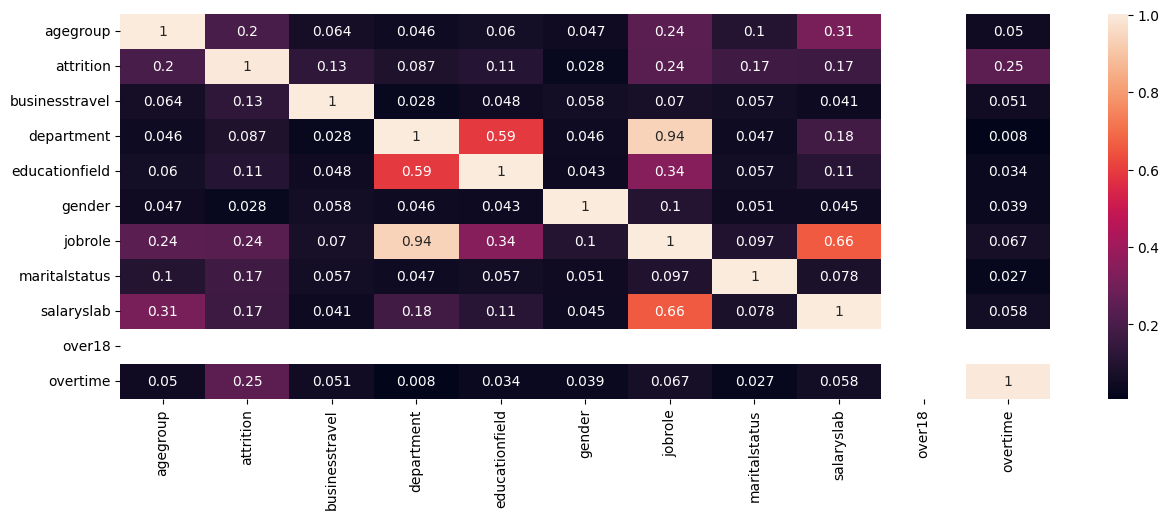

In [315]:
a = df4.select_dtypes(include='object').drop(columns=['empid'])

cramers_v_matrix = pd.DataFrame()

for col1 in a:
    for col2 in a:
        cramers_v_matrix.loc[col1, col2] = cramer_v(a[col1], a[col2])

cramers_v_matrix = cramers_v_matrix.astype(float)

fig, ax = plt.subplots(figsize=(15,5))  
sns.heatmap( cramers_v_matrix, annot=True, ax=ax);